# 다층 퍼셉트론(MultiLayer Perceptron, MLP)으로 텍스트 분류하기

## 1. 다층 퍼셉트론(MultiLayer Perceptron, MLP)

앞서 단층 퍼셉트론의 형태에서 은닉층이 1개 이상 추가된 신경망을 다층 퍼셉트론(MLP)이라고 한다고 배웠습니다. 다층 퍼셉트론은 피드 포워드 신경망(Feed Forward Neural Network, FFNN)의 가장 기본적인 형태입니다. 피드 포워드 신경망은 입력층에서 출력층으로 오직 한 방향으로만 연산 방향이 정해져 있는 신경망을 말합니다.

뒤에서는 순환 신경망(RNN)과 분산 표현(distributed representation)이라는 새로운 개념들을 사용하여 각종 자연어 처리 실습을 하게 될텐데, 이번 챕터의 목적은 위 두 가지 개념없이 지금까지 배운 개념만으로도 자연어 처리를 할 수 있다는 것을 보여주기 위함입니다.

## 2. 케라스의 texts_to_matrix() 이해하기

MLP로 텍스트 분류를 수행하기 전에 이번에 사용할 도구인 케라스 Tokenizer의 texts_to_matrx()를 이해해봅시다.

In [1]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
texts = ['먹고 싶은 사과', '먹고 싶은 바나나', '길고 노란 바나나 바나나', '저는 과일이 좋아요']

In [3]:
t = Tokenizer()
t.fit_on_texts(texts)
print(t.word_index)

{'바나나': 1, '먹고': 2, '싶은': 3, '사과': 4, '길고': 5, '노란': 6, '저는': 7, '과일이': 8, '좋아요': 9}


각 단어에 숫자 1부터 시작하는 정수 인덱스가 부여되었습니다. 이제 텍스트 데이터에 texts_to_matrix()를 사용해보겠습니다. texts_to_matrix()란 이름에서 알 수 있지만, 이 도구는 입력된 텍스트 데이터로부터 행렬(matrix)를 만드는 도구입니다. texts_to_matrx()는 총 4개의 모드를 지원하는데 각 모드는 'binary', 'count', 'freq', 'tfidf'로 총 4개입니다. 우선 'count' 모드를 사용해봅시다.

In [4]:
print(t.texts_to_matrix(texts, mode = 'count')) # texts_to_matrix의 입력으로 texts를 넣고, 모드는 'count'

[[0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]


위의 경우는 총 4개의 모드 중에서 'count' 모드를 사용했을 경우입니다. 'count'를 사용하면 우리가 앞서 배운 문서 단어 행렬(Document-Term Matrix, DTM)을 생성합니다. DTM에서의 인덱스는 앞서 확인한 word_index의 결과입니다.

다만 주의할 점은 각 단어에 부여되는 인덱스는 1부터 시작하는 반면에 완성되는 행렬의 인덱스는 0부터 시작합니다. 실제로 단어의 개수는 9개였지만 완성된 행렬의 열의 개수는 10개인 것과 첫번째 열은 모든 행에서 값이 0인 것을 볼 수 있습니다. 인덱스 0에는 그 어떤 단어도 할당되지 않았기 때문입니다.

우선, 네번째 행을 보겠습니다. 네번째 행은 테스트 데이터에서 네번째 문장을 의미합니다. 네번째 행은 8번째 열, 9번째 열, 10번째 열에서 1의 값을 가집니다. 이는 7번 단어, 8번 단어, 9번 단어가 네번째 문장에서 1개씩 존재함을 의미합니다. 위에서 정수 인코딩 된 결과를 보면 7번 단어는 '저는', 8번 단어는 '과일이', 9번 단어는 '좋아요'입니다. 세번째 행의 첫번째 열의 값은 2인데, 이는 세번째 문장에서 1번 인덱스를 가진 바나나가 두 번 등장했기 때문입니다.

앞서 배웠듯이 DTM은 bag of words를 기반으로 하므로 단어 순서 정보는 보존되지 않습니다. 사실 더 구체적으로는 4개의 모든 모드에서 단어 순서 정보는 보존되지 않습니다. 이제 'binary' 모드를 보겠습니다.

In [5]:
print(t.texts_to_matrix(texts, mode = 'binary'))

[[0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]


DTM과 결과가 매우 유사해보입니다. 다만 세번째 행, 두번째 열의 값이 DTM에서는 2였는데 여기서는 1로 바뀌었습니다. 그 이유는 'binary' 모드는 해당 단어가 존재하는지만 관심을 가지고 해당 단어가 몇 개였는지는 무시하기 때문입니다. 해당 단어가 존재하면 1, 단어가 존재하지 않으면 0의 값을 가집니다. 즉, 단어의 존재 유무로만 행렬을 표현합니다. 이제 'tfidf' 모드를 보겠습니다.

In [6]:
print(t.texts_to_matrix(texts, mode = 'tfidf').round(2)) # 둘째 자리까지 반올림하여 출력

[[0.   0.   0.85 0.85 1.1  0.   0.   0.   0.   0.  ]
 [0.   0.85 0.85 0.85 0.   0.   0.   0.   0.   0.  ]
 [0.   1.43 0.   0.   0.   1.1  1.1  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.1  1.1  1.1 ]]


'tfidf' 모드는 말 그대로 TF-IDF 행렬을 만듭니다. 다만, TF-IDF 챕터에서 배운 기본식이나 사이킷런의 TfidfVectorizer에서 사용하는 식이랑 또 조금 다릅니다. 앞서 배운 기본식에서 TF는 각 문서에서의 각 단어의 빈도였다면 'tfidf' 모드에서는 TF를 각 문서에서의 각 단어의 빈도에 자연 로그를 씌우고 1을 더한 값으로 정의했습니다. idf에서는 앞서 배운 기본식에서 로그는 자연 로그를 사용하고, 로그 안의 분수에 1을 추가로 더했습니다. 물론, 이러한 식을 굳이 기억할 필요는 없고 여전히 TF-IDF의 기존 의도를 갖고 있다고 이해하면 됩니다.

In [7]:
print(t.texts_to_matrix(texts, mode = 'freq').round(2)) # 둘째 자리까지 반올림하여 출력

[[0.   0.   0.33 0.33 0.33 0.   0.   0.   0.   0.  ]
 [0.   0.33 0.33 0.33 0.   0.   0.   0.   0.   0.  ]
 [0.   0.5  0.   0.   0.   0.25 0.25 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.33 0.33 0.33]]


마지막으로 'freq' 모드입니다. 'freq' 모드는 각 문서에서의 각 단어의 등장 횟수를 분자로, 각 문서의 크기(각 문서에서 등장한 모든 단어의 개수의 총 합)를 분모로 하는 표현 방법입니다. 예를 들어 세번째 행을 보겠습니다. 세번째 문장은 '길고 노란 바나나 바나나' 였습니다. 문서의 크기는 4인데, 바나나는 총 2회 등장했습니다. 이에 따라서 세번째 문장에서의 단어 '바나나'의 값은 위의 행렬에서 0.5가 됩니다. 반면에 '길고', '노란'이라는 두 단어는 각 1회 등장했으므로 각자 1/4의 값인 0.25의 값을 가집니다.

## 3. 20개 뉴스 그룹(Twenty Newsgroups) 데이터에 대한 이해

In [9]:
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

사이킷런에서는 20개의 다른 주제를 가진 18,846개의 뉴스 그룹 이메일 데이터를 제공합니다. (LSA 챕터와 동일한 데이터.)

In [10]:
newsdata = fetch_20newsgroups(subset = 'train') # 'train'을 기재하면 훈련 데이터만 리턴한다.

위의 subset의 값으로 'all'을 넣으면 전체 데이터인 18,846개의 샘플을 다운로드할 수 있으며, 'train'을 넣으면 훈련 데이터를, 'test'를 넣으면 테스트 데이터를 다운로드할 수 있습니다. newsdata.keys()를 출력하면 해당 데이터의 속성을 확인할 수 있습니다.

In [11]:
print(newsdata.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


해당 데이터는 data, filenames, target_names, target, DESCR, description이라는 6개 속성을 갖고 있습니다. 이 중 실제로 훈련에 사용할 속성은 이메일 본문인 data와 메일이 어떤 주제인지 기재된 숫자 레이블인 target입니다. 우선 훈련용 샘플의 개수를 보겠습니다.

In [12]:
print('훈련용 샘플의 개수 : {}'.format(len(newsdata.data)))

훈련용 샘플의 개수 : 11314


훈련 샘플은 11,314개가 존재합니다. target_names에는 20개의 주제의 이름을 담고있습니다. 어떤 주제가 있는지 확인해보겠습니다.

In [13]:
print('총 주제의 개수 : {}'.format(len(newsdata.target_names)))
print(newsdata.target_names)

총 주제의 개수 : 20
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


이번 챕터 실습의 목적은 테스트 데이터에서 이메일 본문을 보고 20개의 주제 중 어떤 주제인지를 맞추는 것입니다. 레이블인 target에는 총 0부터 19까지의 숫자가 들어가있는데 첫번째 샘플의 경우에는 몇 번 주제인지 확인해보겠습니다.

In [14]:
print('첫번째 샘플의 레이블 : {}'.format(newsdata.target[0]))

첫번째 샘플의 레이블 : 7


첫번째 샘플의 레이블의 값은 7입니다. 숫자만으로는 앞서 target_names를 통해 확인한 20개의 주제 중에서 어떤 주제를 의미하는지 알 수가 없습니다. 7이 실제로 어떤 주제를 나타내는지는 target_names[] 안에 숫자를 입력하여 알 수 있습니다.

In [15]:
print('7번 레이블이 의미하는 주제 : {}'.format(newsdata.target_names[7]))

7번 레이블이 의미하는 주제 : rec.autos


7번 레이블은 rec.autos라는 주제입니다. 즉, 첫번째 샘플의 주제는 rec.autos입니다. 첫번째 샘플의 본문 내용을 확인해봅시다.

In [16]:
print(newsdata.data[0]) # 첫번째 샘플 출력

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







이메일의 내용을 보니 스포츠 카에 대한 글로 보입니다. 이 글의 레이블은 7이고, 7번 레이블은 rec.autos란 주제를 의미합니다. 이제 훈련에 사용될 메일 본문인 data와 레이블인 target을 데이터프레임으로 만들어서 데이터에 대한 통계적인 정보들을 알아보겠습니다.

In [17]:
data = pd.DataFrame(newsdata.data, columns = ['email']) # data로부터 데이터프레임 생성
data['target'] = pd.Series(newsdata.target) # target 열 추가
data[:5] # 상위 5개 행을 출력

,email,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


메일 본문에 해당하는 email열과 레이블에 해당되는 target 열, 2개의 열로 구성된 데이터프레임이 생성된 것을 볼 수 있습니다.

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   11314 non-null  object
 1   target  11314 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 176.9+ KB


news열은 문자열, target열은 정수형 데이터입니다. 혹시 Null 값을 가진 샘플이 있는지 isnull().values.any()로도 확인 가능합니다.

In [19]:
data.isnull().values.any()

False

False는 데이터에 별도의 Null 값은 없음을 의미합니다. nunique()를 통해 샘플 중 중복을 제거한 개수를 확인할 수 있습니다.

In [20]:
print('중복을 제외한 샘플의 수 : {}'.format(data['email'].nunique()))
print('중복을 제외한 주제의 수 : {}'.format(data['target'].nunique()))

중복을 제외한 샘플의 수 : 11314
중복을 제외한 주제의 수 : 20


이제 레이블 값의 분포를 시각화해보겠습니다.

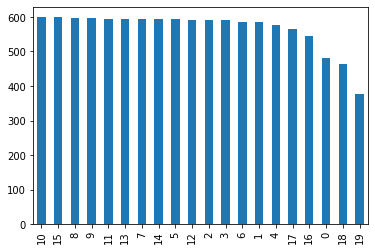

In [21]:
data['target'].value_counts().plot(kind='bar');

10번 레이블의 수가 가장 많고, 19번 레이블의 수가 가장 적으며 대체적으로 400 ~ 600개 사이의 분포를 보입니다. 이번에는 각 레이블이 몇 개 있는지 구체적인 수치로 확인해보겠습니다.

In [22]:
print(data.groupby('target').size().reset_index(name='count'))

    target  count
0        0    480
1        1    584
2        2    591
3        3    590
4        4    578
5        5    593
6        6    585
7        7    594
8        8    598
9        9    597
10      10    600
11      11    595
12      12    591
13      13    594
14      14    593
15      15    599
16      16    546
17      17    564
18      18    465
19      19    377


이제 데이터프레임으로부터 다시 메일 본문과 레이블을 분리하고, 테스트 데이터 또한 불러오겠습니다.

In [23]:
newsdata_test = fetch_20newsgroups(subset='test', shuffle=True) # 'test'를 기재하면 테스트 데이터만 리턴한다.
train_email = data['email'] # 훈련 데이터의 본문 저장
train_label = data['target'] # 훈련 데이터의 레이블 저장
test_email = newsdata_test.data # 테스트 데이터의 본문 저장
test_label = newsdata_test.target # 테스트 데이터의 레이블 저장

훈련 데이터와 테스트 데이터가 모두 준비되었습니다. 케라스의 토크나이저 도구를 사용하여 전처리를 진행해봅시다.

In [24]:
max_words = 10000 # 실습에 사용할 단어의 최대 개수
num_classes = 20 # 레이블의 수

우선 필요한 변수들을 정의합니다. max_words는 이번 실습에서 사용할 최대 단어 개수를 정의하는 변수입니다. 뒤에서 케라스 토크나이저를 사용하면 빈도수 순으로 인덱스를 부여하므로, 빈도수가 가장 높은 상위 max_words 개수만큼의 단어를 사용합니다.

In [25]:
def prepare_data(train_data, test_data, mode): # 전처리 함수
    t = Tokenizer(num_words = max_words) # max_words 개수만큼의 단어만 사용한다.
    t.fit_on_texts(train_data)
    X_train = t.texts_to_matrix(train_data, mode=mode) # 샘플 수 × max_words 크기의 행렬 생성
    X_test = t.texts_to_matrix(test_data, mode=mode) # 샘플 수 × max_words 크기의 행렬 생성
    return X_train, X_test, t.index_word

케라스 토크나이저로 전처리를 수행하는 함수인 prepare_data를 만들었습니다. 해당 함수는 케라스 토크나이저를 통해 단어 토큰화를 수행하고, 앞서 배운 texts_to_matrix()를 사용하여 훈련 데이터와 테스트 데이터를 'binary', 'count', 'tfidf', 'freq' 4개의 모드 중 사용자가 정한 모드로 변환합니다.

In [26]:
X_train, X_test, index_to_word = prepare_data(train_email, test_email, 'binary') # binary 모드로 변환
y_train = to_categorical(train_label, num_classes) # 원-핫 인코딩
y_test = to_categorical(test_label, num_classes) # 원-핫 인코딩

메일 본문에 대해서는 'binary' 모드로 변환하고, 훈련 데이터와 테스트 데이터의 레이블은 원-핫 인코딩을 수행하였습니다.

In [27]:
print('훈련 샘플 본문의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 본문의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 본문의 크기 : (11314, 10000)
훈련 샘플 레이블의 크기 : (11314, 20)
테스트 샘플 본문의 크기 : (7532, 10000)
테스트 샘플 레이블의 크기 : (7532, 20)


훈련 데이터와 테스트 데이터 모두 메일 본문의 크기가 샘플의 수 × 10,000의 행렬로 변환되었는데, 열의 개수가 10,000인 것은 위의 prepard_data 함수 내부에서 Tokenizer의 num_words의 인자로 max_words를 지정해주었기 때문입니다. 사실 단어의 정수 인덱스는 1부터 시작하지만, 행렬의 인덱스는 0부터 시작하여 0번 인덱스는 사용되지 않으므로 실제로 행렬에는 빈도수 기준 상위 9,999개의 단어가 표현된 셈입니다. 빈도수 상위 1번 단어와 9,999번 단어를 확인해보겠습니다.

In [28]:
print('빈도수 상위 1번 단어 : {}'.format(index_to_word[1]))
print('빈도수 상위 9999번 단어 : {}'.format(index_to_word[9999]))

빈도수 상위 1번 단어 : the
빈도수 상위 9999번 단어 : mic


불용어에 해당되는 단어 'the'가 빈도수 상위 1번 단어가 된 것을 확인할 수 있습니다.

## 4. 다층 퍼셉트론(Multilayer Perceptron, MLP)을 사용하여 텍스트 분류하기

이제 모델을 설계해보겠습니다. 우선 모델 설계에 필요한 도구들을 임포트합니다.

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

다층 퍼셉트론을 설계합니다.

In [30]:
def fit_and_evaluate(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(Dense(256, input_shape=(max_words,), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.1)
    score = model.evaluate(X_test, y_test, batch_size=128, verbose=0)
    return score[1]

모델 설계를 fit_and_evaluate라는 함수 내에 정의하였는데, 모델을 함수 내에 정의한 이유는 이번 실습에서는 입력값을 바꿔가면서 모델을 여러번 호출하기 위함입니다. 우선은 모델의 아키텍처에 집중해보겠습니다.

![Alt text]( multilayerperceptron.png )

위의 그림은 현재 설계한 신경망의 구조를 보여줍니다. 현재 설계한 다층 퍼셉트론은 총 4개의 층을 가지고 있습니다. max_words의 크기를 가진 입력층, 256개의 뉴런을 가진 첫번째 은닉층, 128개의 뉴런을 가진 두번째 은닉층, num_classes의 크기를 가진 출력층입니다. 또한 이번에 설계한 다층 퍼셉트론은 은닉층이 2개이므로 깊은 신경망(Deep Neural Network, DNN)입니다.

코드로 돌아가보겠습니다. 위 모델에서는 과적합을 막기 위해서 두 번의 드롭아웃(Dropout)을 적용하였습니다. 이 문제는 다중 클래스 분류 문제입니다. 여러 개의 선택지 중에서 하나의 선택지를 고르는 문제인데, 이 경우 20개의 주제 중에서 모델은 자신이 정답이라고 생각하는 1개의 주제를 예측해야 합니다. 다중 클래스 분류 문제이므로 출력층의 활성화 함수로는 소프트맥스 함수를 사용하고, 손실 함수로는 크로스 엔트로피(categorical_crossentropy) 함수를 사용하였습니다.

모델을 훈련시켜보겠습니다. 이번에는 앞서 배운 texts_to_matrix()의 4개의 모드에 대해서 전부 모델의 결과를 확인해보겠습니다.

In [31]:
modes = ['binary', 'count', 'tfidf', 'freq'] # 4개의 모드를 리스트에 저장.

for mode in modes: # 4개의 모드에 대해서 각각 아래의 작업을 반복한다.
    X_train, X_test, _ = prepare_data(train_email, test_email, mode) # 모드에 따라서 데이터를 전처리
    score = fit_and_evaluate(X_train, y_train, X_test, y_test) # 모델을 훈련하고 평가.
    print(mode+' 모드의 테스트 정확도:', score)

Train on 10182 samples, validate on 1132 samples
Epoch 1/5
10182/10182 [==============================] - 3s 283us/sample - loss: 2.2784 - accuracy: 0.3375 - val_loss: 0.9487 - val_accuracy: 0.8242
Epoch 2/5
10182/10182 [==============================] - 2s 186us/sample - loss: 0.8610 - accuracy: 0.7652 - val_loss: 0.4791 - val_accuracy: 0.8772
Epoch 3/5
10182/10182 [==============================] - 2s 188us/sample - loss: 0.4309 - accuracy: 0.8898 - val_loss: 0.3456 - val_accuracy: 0.9108
Epoch 4/5
10182/10182 [==============================] - 2s 200us/sample - loss: 0.2657 - accuracy: 0.9304 - val_loss: 0.3112 - val_accuracy: 0.9161
Epoch 5/5
10182/10182 [==============================] - 2s 209us/sample - loss: 0.1786 - accuracy: 0.9573 - val_loss: 0.2877 - val_accuracy: 0.9152
binary 모드의 테스트 정확도: 0.8307223
Train on 10182 samples, validate on 1132 samples
Epoch 1/5
10182/10182 [==============================] - 3s 275us/sample - loss: 2.7537 - accuracy: 0.2486 - val_loss: 1.6366 -

각 모드에 대해서 총 5회의 에포크를 수행하는데, 각 모드에 대한 정확도는 다음과 같이 나왔습니다.

대체적으로 82% ~ 83%의 비슷한 정확도를 보이는데, 'freq' 모드에서만 정확도가 69%가 나왔습니다. 아무래도 'freq' 모드는 이번 문제를 풀기위한 적절한 전처리 방법이 아니었던 것 같습니다.